## 标记与术语
- 特征(features):例如数据的种类(一般以列存储)
- 样本(samples):一般以行存储,数据列表  
$x^i_j$指第$i$个训练样本,训练集的第$j$维(第$j$个特征)
>这种标记输入输出均可

>另外,机器学习是一回事,这本书中的python代码非常优美,值得学习

# 为分类问题训练简单的机器学习算法
在这一部分,我们构造一个简单的线性分类算法实现我们的分类任务


## 早期的机器学习模型
最早的机器学习模型是通过模拟神经元实现的  
我们可以定义一个决定函数$\phi(x)$来从输入得到输出
通过将权重矢量与输入矢量点乘后通过一个阈值函数得到输出.
因此,通过计算$sign(\omega^Tx+\omega_0)$即可得到一个**二分类输出**

### 学习的逻辑
每一次学习,都需要让计算结果更加接近,因此需要更新权重矢量得到$\Delta \omega$  
而$\Delta \omega=\eta(y^i-\hat{y}^i)x$  
式中的$\eta$被称为**学习率**  
其过程可以被总结为  
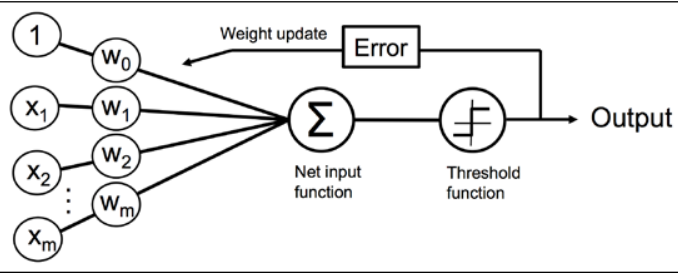

### 实现
下面我们尝试构造一个类来解决这个问题

In [4]:
import numpy as np

class Perception:
    def __init__(self,eta=0.01,n_iter=100,random_state=1) -> None:
        self.eta=eta
        self.n_iter=n_iter
        self.random_state=random_state
    def fitdata(self,X,y):
        self.errors_=[]#aa_下划线代表运行后才存在的属性
        rs=np.random.RandomState(self.random_state)#种子生成随机数
        self.w_=rs.normal(scale=0.1,size=1+X.shape[1])
        for i in range(self.n_iter):
            error=0
            for x,yreal in zip(X,y):
                ytest=np.where(np.dot(x,self.w_[:-1])+self.w_[-1]>0,1,-1)
                self.w_[:-1]+=self.eta*(yreal-ytest)*x
                self.w_[-1]+=self.eta*(yreal-ytest)
                error+=np.count_nonzero(yreal-ytest)
            self.errors_.append(error)
            if(error==0):
                print("The fitting have completed")
                return
        print("The max iteration have reached")
        return
    def net_input(self,X):
        return np.dot(X,self.w_[:-1])+self.w_[-1]
    def predict(self,X):
        return np.where(self.net_input(X)>=0.0,1,-1) 


在这个类中我们定义`fit`实现拟合,拟合之后会有两个属性,分别为`w_`和`errors_`一个记录了线性参数,另外一个记录了误差

## 使用鸢尾花数据集训练这个分类模型
为了测试我们这个的效果,我们将对山鸢尾和变色秋海棠两种不同的花进行分类,虽然特征不一定要是二维的,但是为了展示方便,我们使用两个特征萼片长度和花瓣长度作为特征.

我们首先使用`pandas`将数据从数据库中加载出来,并且看看大概

In [5]:
import pandas as pd
df=pd.read_csv('https://archive.ics.uci.edu/ml/'
               'machine-learning-databases/iris/iris.data',
               header=None)
df.tail()               

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


接下来,我们将前50个山鸢尾和前50个变色秋海棠的记录提取出来,分别标记为-1和1

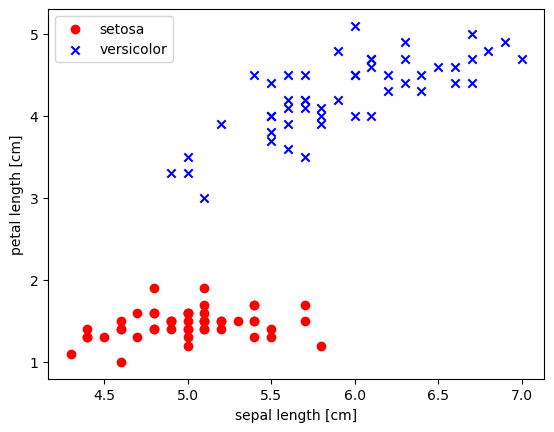

In [6]:
import matplotlib.pyplot as plt
import numpy as np

y=df.iloc[0:100,4].values
y=np.where(y=='Iris-setosa',-1,1)

X=df.iloc[0:100,[0,2]].values

plt.scatter(X[y==-1,0],X[y==-1,1],color='red',marker='o',label='setosa')
plt.scatter(X[y==1,0],X[y==1,1],color='blue',marker='x',label='versicolor')
plt.xlabel("sepal length [cm]")
plt.ylabel("petal length [cm]")
plt.legend(loc='best')
plt.show()

我们可以从上面那张图中看出来两种花可以被很好的区分开来,接下来我们来训练一下试试

The fitting have completed


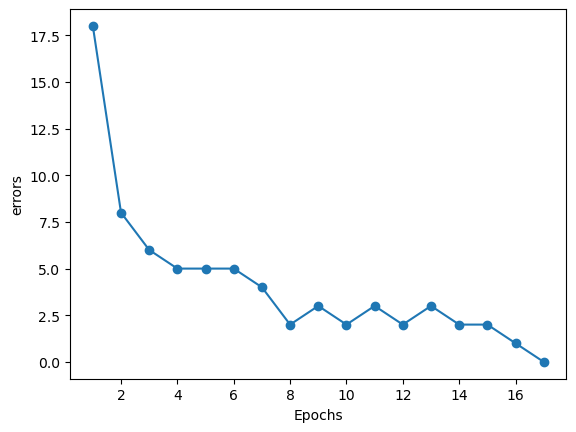

In [7]:
model=Perception(0.001)#这里特地将eta调的很小使得梯度下降过程明显
model.fitdata(X,y)
plt.plot(range(1,len(model.errors_)+1),model.errors_,'o-')
plt.xlabel('Epochs')
plt.ylabel('errors')
plt.show()

可以注意到,最后的`errors`已经为0,为了进一步观察我们拟合的效果,我们将定义一个函数用来描绘决定区间

In [8]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X,y,classifier,resolution=0.02):
    #setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])# unique函数可以找到所有独立的元素
    #plot the surface
    x1_min,x1_max=X[:,0].min()-1,X[:,0].max()+1
    x2_min,x2_max=X[:,1].min()-1,X[:,1].max()+1#X1,X2分别是X轴Y轴
    xx1,xx2=np.meshgrid(np.arange(x1_min,x1_max,resolution),
                        np.arange(x2_min,x2_max,resolution))
    Z=classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)#这里要将数组展平(这里面的向量操作非常有趣)
    Z=Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,Z,alpha=0.3,cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    #plot class samples
    for idx,cl in enumerate(np.unique(y)):#这里使用enumerate来同时获得标签
        plt.scatter(x=X[y==cl,0],
                    y=X[y==cl,1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolors='black')

接下来,我们来展示一下绘图的结果

C:\Users\lison\AppData\Local\Temp\ipykernel_25612\3891387916.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0],


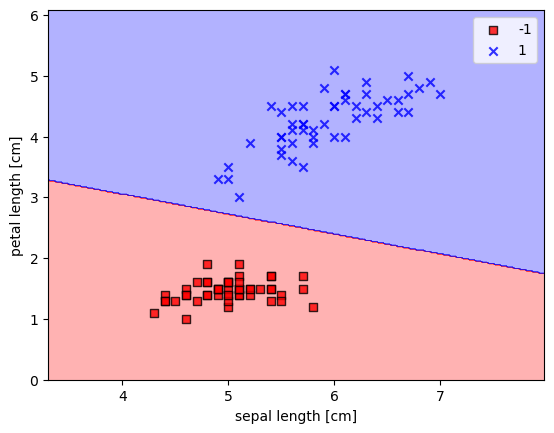

In [9]:
plot_decision_regions(X,y,classifier=model)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='best')
plt.show()

>刚刚我们实现的可以被认为是一个单层的神经网络

## 可适应性线性神经元与学习收敛
在这一部分,我们将研究另外一种单层神经网络:ADAptive LInear NEuron(`Adaline`)  
这种算法非常有趣因为其展现了关于定义和最小化连续损失函数的方法,这便于让我们理解之后我们所用的相关函数  
`Adaline`算法与感知机最关键的区别在于权重函数是使用一个线性激发函数而非一个单位阶跃函数,在`Adaline`算法中
这样一个线性激发函数就是网络输入的线性函数因此有:  
$$\phi(w^Tx)=w^Tx$$
虽然激发函数是用在学习权重的,但我们也可以用其来评估最后结果,`ADaline`的特殊性可以用下面一张图来展示  
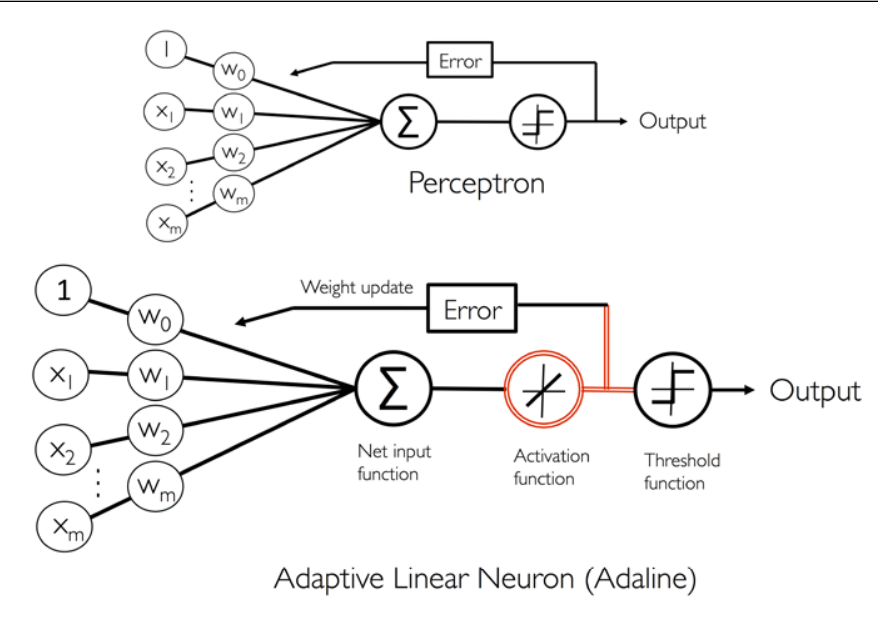

### 使用梯度下降法最小化损失函数
对于`Adaline`而言,我们可以定义损失函数$J$并且使用方均根法得到权重
$$J(\omega)=\frac{1}{2}\sum_i(y^{(i)}-\phi(z^{(i)}))^2$$
在该式中,$\frac{1}{2}$只是为了方便求梯度,接下来我们就可以使用一个非常有效的方法**梯度下降法**来使损失函数最小,原理为
$$\Delta \omega=-\eta\nabla J(\omega)$$
梯度的计算为
$$\frac{\partial J}{\partial \omega_j}=-\sum_i(y^{(i)}-\phi(z^{(i)}))x^{(i)}_j$$
>需要注意一个计算上的不同,在此处我们的计算是**所有样本一起算的**而不是像之前一样**一个样本更新一次**

### 实现

In [10]:
class AdalineGD:
    def __init__(self,eta=0.001,n_iter=100,random_state=1) -> None:
        self.eta=eta
        self.n_iter=n_iter
        self.random_state=random_state

    def fit(self,X,y):
        rgen=np.random.RandomState(self.random_state)
        self.w_=rgen.normal(0.0,0.1,size=1+X.shape[1])
        self.cost_=[]
        for i in range(self.n_iter):
            err,errg,errw0=self._calc_cost(X,y)
            self.cost_.append(err)
            self.w_[1:]+=-self.eta*errg
            self.w_[0]+=-self.eta*errw0
            
    def _calc_cost(self,X,y):
        yp=(np.dot(X,self.w_[1:].reshape(-1,1))+self.w_[0]).reshape(1,-1)
        #print(yp)
        err=np.sum((yp[0]-y)**2)/2
        errg=np.dot((yp[0]-y),X)
        errw0=np.sum(yp[0]-y)
        return err,errg[0],errw0

    def predict(self,X):
        return np.where(np.dot(X,self.w_[1:])+self.w_[0]>0,1,-1)

接下来,我们将之前的数据输入进去试一试看看如何

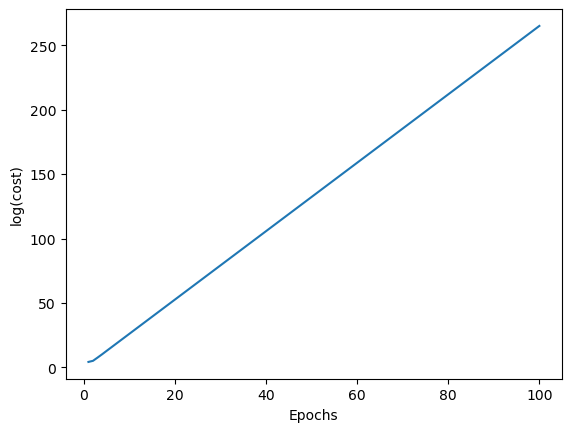

array([-3.89410517e+55, -2.18332011e+56, -2.18332011e+56])

In [11]:
y=df.iloc[0:100,4].values
y=np.where(y=='Iris-setosa',-1,1)

X=df.iloc[0:100,[0,2]].values
adamodel=AdalineGD()
adamodel.fit(X,y)
plt.plot(range(1,len(adamodel.cost_)+1),np.log(adamodel.cost_),'-')
plt.xlabel('Epochs')
plt.ylabel('log(cost)')
plt.show()
adamodel.w_

可以发现,程序直接爆炸,此时可能是$eta$调大了,我们把$eta$调为1E-5试试

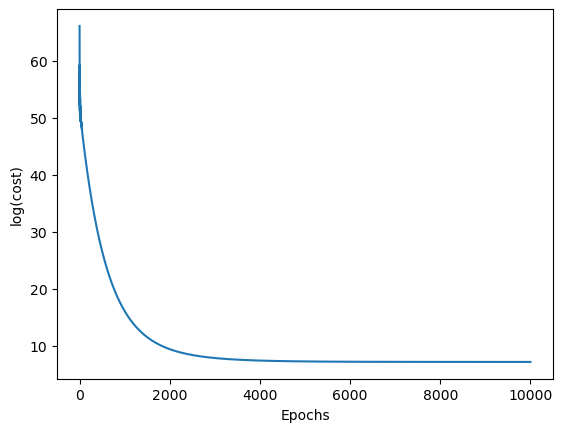

array([-3.33272936,  0.39707341,  0.40543187])

In [12]:
y=df.iloc[0:100,4].values
y=np.where(y=='Iris-setosa',-1,1)

X=df.iloc[0:100,[0,2]].values
adamodel=AdalineGD(eta=4E-4,n_iter=10000)
adamodel.fit(X,y)
plt.plot(range(1,len(adamodel.cost_)+1),adamodel.cost_,'-')
plt.xlabel('Epochs')
plt.ylabel('log(cost)')
plt.show()
adamodel.w_

可以注意到,逐渐在趋向一个稳定值,这之中存在的问题可以用下图展示  
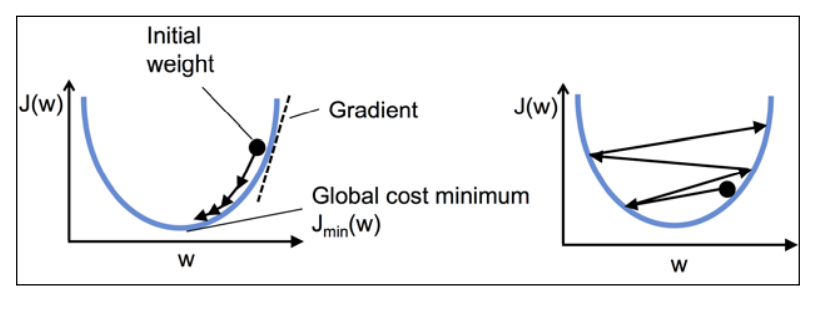

C:\Users\lison\AppData\Local\Temp\ipykernel_25612\3891387916.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0],


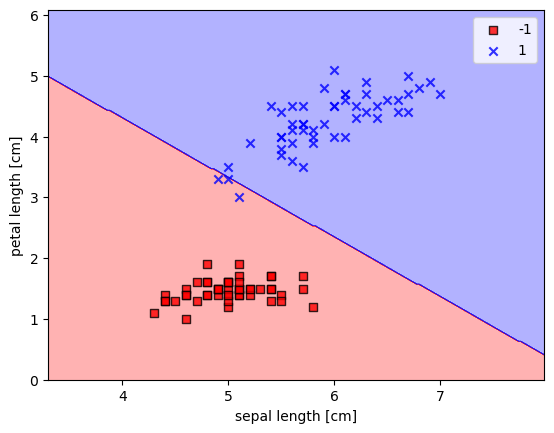

In [13]:
plot_decision_regions(X,y,classifier=adamodel)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='best')
plt.show()

可以注意到,这种计算方法非常依赖初值,而且最后也没有完全分开来,并不是非常理想,因此需要优化

### 使用标准化提升梯度下降法效果
标准化是一个机器学习过程中的非常重要的手段,在这一部分中,我们使用一种*正态分布标准化*  
这种方法假定数据呈现出正态分布,处理的手段是将数据减去平均值并且除以数据的标准差,即:
$$x_j'=\frac{x_j-\mu}{\sigma}$$
这么做的好处在于可以让优化器更快的实现达到最低值

In [14]:
X_std=np.copy(X)
X_std[:,0]=(X[:,0]-X[:,0].mean())/X[:,0].std()
X_std[:,1]=(X[:,1]-X[:,1].mean())/X[:,1].std()

在标准化之后,我们将数据输入到前面的模型中

C:\Users\lison\AppData\Local\Temp\ipykernel_25612\3891387916.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0],


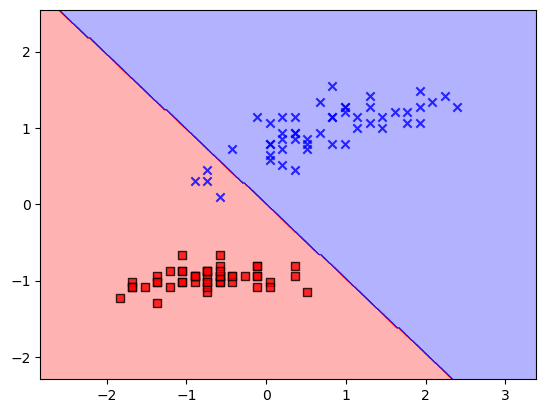

In [26]:
stdada=AdalineGD(1E-3,150,1)
stdada.fit(X_std,y)
plot_decision_regions(X_std,y,classifier=stdada)

效果变好了一些(但实际上初值问题仍然存在)

## 大规模机器学习与随机梯度下降法
现在我们考虑一个非常巨大的数据集(可能有上百万的数据)  
我们现在用另外一种方式,对于每一个数据,都对$\Delta \omega$进行一次更新,实际上随机梯度下降法达到稳定的速度快于批量梯度下降法(虽然前者看起来是后者的近似)

为了更好的进行梯度下降法,我们需要对数据进行一个更好的随机化处理  
同时,这么做还有一个好处,因为在一些网络程序之中,数据和模型的训练是同步进行的